# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
feat_info[50:] #.head(30)

,attribute,information_level,type,missing_or_unknown
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0]
51,ANZ_HH_TITEL,building,numeric,[]
52,GEBAEUDETYP,building,categorical,"[-1,0]"
53,KONSUMNAEHE,building,ordinal,[]
54,MIN_GEBAEUDEJAHR,building,numeric,[0]
55,OST_WEST_KZ,building,categorical,[-1]
56,WOHNLAGE,building,mixed,[-1]
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]"
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [6]:
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
azdias_2 = azdias.copy()

In [8]:
azdias_2.isnull().sum() # age does not have null before converting 

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
feat_info.loc[feat_info['attribute']=='AGER_TYP','missing_or_unknown'].values
#values are string not list

array(['[-1,0]'], dtype=object)

In [10]:
#test one col
azdias.loc[azdias.iloc[:,0].isin([-1,0]),'AGER_TYP'] = np.nan

In [11]:
# Identify missing or unknown data values and convert them to NaNs.
import ast
for col, vals in enumerate(feat_info['missing_or_unknown']):
    if 'XX' not in vals and "X" not in vals:
        #print (col, ast.literal_eval(vals))
        vals = ast.literal_eval(vals) 
        ## a very handy function to convert string list to real list, only work when list contains the same data type
        ## first convert all numeric values in the list to NA
        azdias.iloc[:,col][azdias.iloc[:,col].isin(vals)] = np.nan

/Users/lalago31/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
## deal with list that contains "XX" separately
#azdias.loc[azdias['AGER_TYP'].isin([-1,0]),'AGER_TYP']= np.nan
azdias.loc[azdias['CAMEO_DEUG_2015'].isin([-1,'X']),'CAMEO_DEUG_2015']= np.nan
azdias.loc[azdias['CAMEO_DEU_2015'].isin(['XX']),'CAMEO_DEU_2015']= np.nan
azdias.loc[azdias['CAMEO_INTL_2015'].isin([-1,'XX']),'CAMEO_INTL_2015']= np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

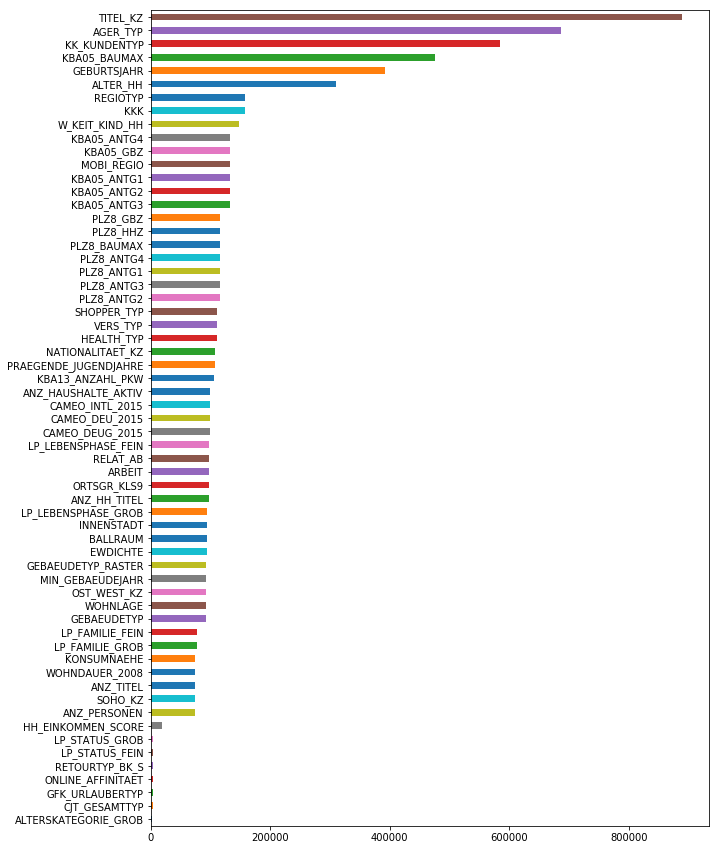

In [14]:
# Investigate patterns in the amount of missing data in each column.
na_values=azdias.isnull().sum()
plt.figure(figsize=(10,15))
na_values[azdias.isnull().sum()>0].sort_values().plot.barh()

#### * missing values definitely have some patterns. they appear in the same count for a group of related features. for example, attributes starting with "KBA" have the same NA count, "PLZ8" feature group also has the same NA count. etc. from the feature name, I can tell they are clusters of features that give information about the same aspects/topics.

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
pd.Series(na_values[azdias.isnull().sum()>0]/azdias.shape[0]).sort_values(ascending=False)

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

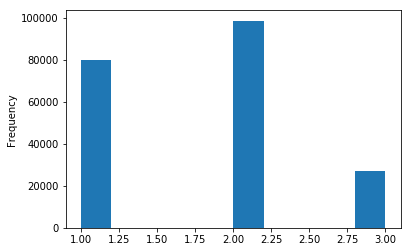

In [16]:
azdias.AGER_TYP.plot.hist()

#### * most of the features have less than 20% missing values. "TITEL_KZ" has more than 99% NA values.  AGER_TYP and KK_KUNDENTYP also have more than 60% NAs. Three other columns have NA between 30% to 60%. I will remove top 6 columns with highest NA% from the dataset.     

In [17]:
azdias_3= azdias.copy()

In [18]:
azdias.drop('TITEL_KZ',axis=1,inplace= True)

In [19]:
azdias.drop(['AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1,inplace= True)

In [20]:
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.1.2: Assess Missing Data in Each Column

Missing values definitely have some patterns. they appear with the same count for a group of related features. for example, attributes starting with "KBA" have the same na count, "PLZ8" feature group has the same missing value count. etc. from the feature name, I can tell they are clusters of features that give information about the same aspects/topics. According to the bar chart, most of the features have less than 20% missing values, except 6 columns - 'AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH', 'TITEL_KZ'. These 6 have removed from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
pd.Series(azdias.isnull().sum(axis=1).sort_values(ascending=False)).head(110) 
#collapse column-> sum by row, default is by column(axis=0)

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
691467    47
691470    47
139555    47
690845    47
689751    47
140063    47
689969    47
689985    47
689986    47
689991    47
689992    47
689996    47
690001    47
690007    47
690016    47
690018    47
690024    47
690026    47
690027    47
690102    47
690111    47
690115    47
690126    47
140181    47
689943    47
689942    47
689832    47
689760    47
689764    47
689765    47
Length: 110, dtype: int64

In [22]:
azdias.shape

(891221, 79)

In [23]:
np.unique(azdias.isnull().sum(axis=1),return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49]),
 array([623209,  15738,  27926,  17629,  12607,  22515,  13771,  13714,
         24592,   3042,   5410,   1127,    766,   3255,   2243,   4743,
          2505,    677,    428,   1180,    349,    150,    129,    132,
            69,     55,     59,     24,      5,     12,      6,      3,
           206,   2985,  10816,   3911,     84,    538,    421,     77,
           137,    356,     21,  27369,    155,    494,  45578,      1,
             2]))

#### * out of remaining 79 columns, records that have missing values in more than 50% of the columnns can be allocated to a separate group. I am going to set a threshold of 30. rows that have NA in more than 30 columns will be selected into a separate dataset and I will work with the subset with NA in <=30 columns.

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_4 = azdias.copy()
azdias_fewNA = azdias[azdias.isnull().sum(axis=1)<=30]
azdias_lotsNA = azdias[azdias.isnull().sum(axis=1)>30]

In [25]:
azdias_fewNA.shape

(798067, 79)

In [26]:
azdias_lotsNA.shape

(93154, 79)

In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
pd.Series(azdias.isnull().sum(axis=0).sort_values()).head(8) 
# plot on these 5 columns

ZABEOTYP      0
SEMIO_REL     0
SEMIO_MAT     0
SEMIO_VERT    0
SEMIO_LUST    0
SEMIO_ERL     0
SEMIO_KULT    0
SEMIO_RAT     0
dtype: int64

In [28]:
plot_columns=pd.Series(azdias.isnull().sum(axis=0).sort_values()).head(5).index

Text(0.5,1,'ZABEOTYP in lots of NA Dataset')

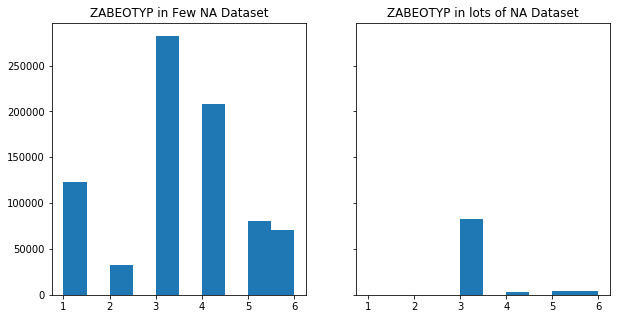

In [29]:
# sample 
f, axs = plt.subplots(1,2, sharex = True, sharey=True, figsize = (10,5))
ax1,ax2= axs.flatten()
ax1.hist(azdias_fewNA['ZABEOTYP'])
ax2.hist(azdias_lotsNA['ZABEOTYP'])
ax1.set_title('ZABEOTYP in Few NA Dataset')
ax2.set_title('ZABEOTYP in lots of NA Dataset')

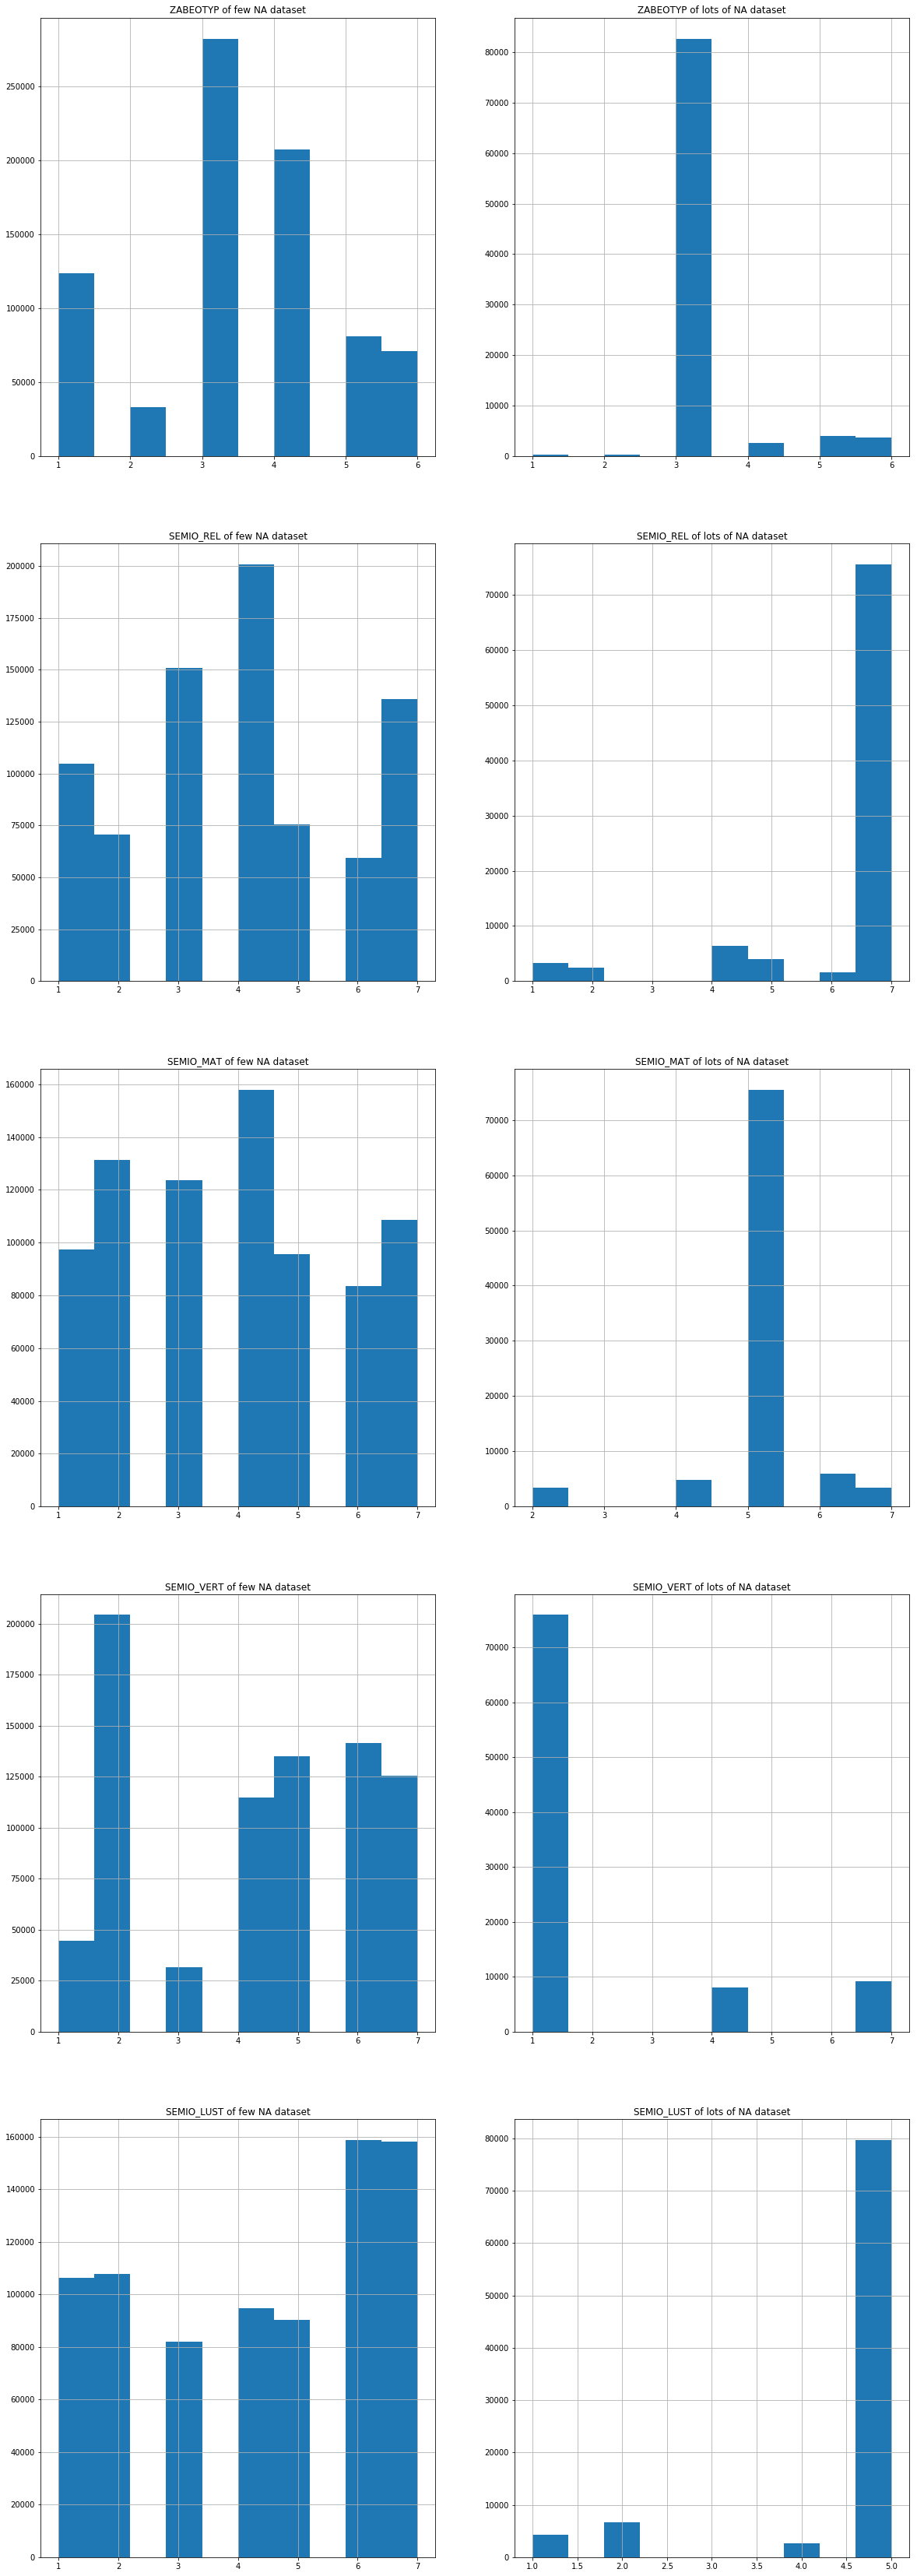

In [30]:
f, axes = plt.subplots(5,2,  figsize = (20,60))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()
ax = [i for i in axes.flatten()]
for i in range(len(plot_columns)):
    col = plot_columns[i]
    i = i + i
    j = i + 1
    azdias_fewNA[col].hist(ax=ax[i])
    azdias_lotsNA[col].hist(ax=ax[j])
    ax[i].set_title(col + ' of few NA dataset')
    ax[j].set_title(col + ' of lots of NA dataset')

#### Discussion 1.1.3: Assess Missing Data in Each Row

#### * It shows clearly different patterns between the dataset with few NA (A) and dataset with lots of NA(B)- A usually has a variety of values and counts of values are well distributed while data points in B usually concentrates on one single value. I think it's necessary to revisit the subset B later but I will work with the subset A for now.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
feat_info.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [32]:
# How many features are there of each data type?
print('there are {} categorical features'.format(feat_info.loc[feat_info.type=='categorical',:].shape[0]) )
print('there are {} numeric features'.format(feat_info.loc[feat_info.type=='numeric',:].shape[0]) )
print('there are {} interval features'.format(feat_info.loc[feat_info.type=='interval',:].shape[0]) )
print('there are {} ordinal features'.format(feat_info.loc[feat_info.type=='ordinal',:].shape[0]) )
print('there are {} mixed features'.format(feat_info.loc[feat_info.type=='mixed',:].shape[0]) )

there are 21 categorical features
there are 7 numeric features
there are 1 interval features
there are 49 ordinal features
there are 7 mixed features


In [197]:
feat_info.loc[feat_info.type=='ordinal',:]

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
14,HEALTH_TYP,person,ordinal,"[-1,0]"
23,RETOURTYP_BK_S,person,ordinal,[0]
24,SEMIO_SOZ,person,ordinal,"[-1,9]"


In [160]:
feat_info.loc[feat_info.type=='interval',:]

,attribute,information_level,type,missing_or_unknown
43,ALTER_HH,household,interval,[0]


In [161]:
feat_info.loc[feat_info.type=='categorical',:]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [162]:
feat_info.loc[feat_info.type=='mixed',:]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_col = feat_info.loc[feat_info.type=='categorical','attribute'].unique()
dataset_columns = azdias_fewNA.columns
dataset_columns.join(categorical_col, how='inner') # remaining categorical col in azdias_fewNA subset

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object')

In [34]:
categorical_columns = dataset_columns.join(categorical_col, how='inner').tolist()

In [35]:
# get the categorical columns w/ 2 levels
for c in categorical_columns:
    if len(azdias_fewNA[c].unique())==2:
        print(c )
        print(azdias_fewNA[c].value_counts())
        print('\n')

ANREDE_KZ
2    416181
1    381886
Name: ANREDE_KZ, dtype: int64


GREEN_AVANTGARDE
0    622842
1    175225
Name: GREEN_AVANTGARDE, dtype: int64


SOHO_KZ
0.0    791350
1.0      6717
Name: SOHO_KZ, dtype: int64


OST_WEST_KZ
W    629525
O    168542
Name: OST_WEST_KZ, dtype: int64




In [36]:
# only OST_WEST_KZ has string values and has to be changed to label encoded
from sklearn.preprocessing import LabelEncoder
azdias_fewNA['OST_WEST_KZ'] = LabelEncoder().fit_transform(azdias_fewNA.OST_WEST_KZ)

/Users/lalago31/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
azdias_fewNA.OST_WEST_KZ.value_counts()

1    629525
0    168542
Name: OST_WEST_KZ, dtype: int64

In [38]:
# get the categorical columns w/ more than 2 levels
for c in categorical_columns:
    if len(azdias_fewNA[c].unique())>2:
        print(c , len(azdias_fewNA[c].unique()))

CJT_GESAMTTYP 7
FINANZTYP 6
GFK_URLAUBERTYP 13
LP_FAMILIE_FEIN 12
LP_FAMILIE_GROB 6
LP_STATUS_FEIN 11
LP_STATUS_GROB 6
NATIONALITAET_KZ 4
SHOPPER_TYP 5
VERS_TYP 3
ZABEOTYP 6
GEBAEUDETYP 7
CAMEO_DEUG_2015 10
CAMEO_DEU_2015 45


In [39]:
azdias_fewNA['CJT_GESAMTTYP'].value_counts()

4.0    198296
3.0    147220
2.0    141269
5.0    111114
6.0    102108
1.0     93311
Name: CJT_GESAMTTYP, dtype: int64

In [40]:
azdias_fewNA.LP_FAMILIE_FEIN.value_counts()

1.0     402556
10.0    128974
2.0      98555
11.0     48746
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64

In [171]:
# Re-encode categorical variable(s) to be kept in the analysis.
## only keep categorical variables with less than 10 levels.
keep_categorical = [c for c in categorical_columns if len(azdias_fewNA[c].unique())>2 and len(azdias_fewNA[c].unique())<=10]
azdias_fewNA_encoded = pd.get_dummies(azdias_fewNA.drop(['CAMEO_DEU_2015','LP_STATUS_FEIN','GFK_URLAUBERTYP','LP_FAMILIE_FEIN'],axis=1), columns= keep_categorical)

In [172]:
keep_categorical

['CJT_GESAMTTYP',
 'FINANZTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [173]:
azdias_fewNA_encoded.columns[-50:]

Index(['CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESAMTTYP_6.0',
       'FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4',
       'FINANZTYP_5', 'FINANZTYP_6', 'LP_FAMILIE_GROB_1.0',
       'LP_FAMILIE_GROB_2.0', 'LP_FAMILIE_GROB_3.0', 'LP_FAMILIE_GROB_4.0',
       'LP_FAMILIE_GROB_5.0', 'LP_STATUS_GROB_1.0', 'LP_STATUS_GROB_2.0',
       'LP_STATUS_GROB_3.0', 'LP_STATUS_GROB_4.0', 'LP_STATUS_GROB_5.0',
       'NATIONALITAET_KZ_1.0', 'NATIONALITAET_KZ_2.0', 'NATIONALITAET_KZ_3.0',
       'SHOPPER_TYP_0.0', 'SHOPPER_TYP_1.0', 'SHOPPER_TYP_2.0',
       'SHOPPER_TYP_3.0', 'VERS_TYP_1.0', 'VERS_TYP_2.0', 'ZABEOTYP_1',
       'ZABEOTYP_2', 'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5', 'ZABEOTYP_6',
       'GEBAEUDETYP_1.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_3.0',
       'GEBAEUDETYP_4.0', 'GEBAEUDETYP_5.0', 'GEBAEUDETYP_6.0',
       'GEBAEUDETYP_8.0', 'CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2',
       'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5',
       'CAMEO_DEUG_201

#### Discussion 1.2.1: Re-Encode Categorical Features
1. I found the one binary categorical column that has string values and label encoded it to numeric values(0/1)
2. Among the multi-level categorical columns, I only kept the ones with less or equal to 10 levels and dummy encoded them. The rest of high levels categorical columns are dropped because they would increase the dimension of the data too much. In fact, I found in the data dictionary that "LP_STATUS_FEIN" is simply a more granular version of "LP_STATUS_GROB". since I will keep LP_STATUS_GROB, there won't be too much information loss in the dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

> re encode PRAEGENDE_JUGENDJAHRE

In [198]:
azdias_fewNA_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182985
8.0     141630
10.0     85808
5.0      84692
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [199]:
azdias_fewNA_encoded['PRAEGENDE_JUGENDJAHRE'].isnull().sum() #28k null values of PRAEGENDE_JUGENDJAHRE

28758

In [200]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_fewNA_encoded['GENERATION'] = azdias_fewNA_encoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda x:6 if x>=1 and x<=2\
                                                                                         else 5 if x>=3 and x<=4 \
                                                                                        else 4 if x>=5 and x<=7\
                                                                                         else 3 if x>=8 and x<=9\
                                                                                        else 2 if x>=10 and x<=13 \
                                                                                         else 1 if x>13 else np.nan )
## the larger the value, the younger the generation. ie. 1-2 are 40s ppl and oldest generation so I encode it in the largest value.
# I will treat this new engineered feature as a ordinal feature.
azdias_fewNA_encoded['MOVEMENT'] = azdias_fewNA_encoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda x:0 if (x%2==1 and x>=1 and x<=5) or (x%2==0 and x>=8)\
                                                                                       else 1 if (x%2==0 and x>=1 and x<=6) or (x%2==1 and x>6)
                                                                                       else np.nan)

In [201]:
azdias_fewNA_encoded[['PRAEGENDE_JUGENDJAHRE','GENERATION','MOVEMENT']].head(10)

,PRAEGENDE_JUGENDJAHRE,GENERATION,MOVEMENT
1,14.0,1.0,0.0
2,15.0,1.0,1.0
3,8.0,3.0,0.0
4,8.0,3.0,0.0
5,3.0,5.0,0.0
6,10.0,2.0,0.0
7,8.0,3.0,0.0
8,11.0,2.0,1.0
9,15.0,1.0,1.0
10,3.0,5.0,0.0


In [202]:
azdias_fewNA_encoded['GENERATION'].unique()

array([ 1.,  3.,  5.,  2.,  4., nan,  6.])

In [203]:
azdias_fewNA_encoded['GENERATION'].isnull().sum()

28758

In [204]:
azdias_fewNA_encoded['MOVEMENT'].isnull().sum()

28758

> re-encode CAMEO_INTL_2015

In [205]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_fewNA_encoded["CAMEO_INTL_2015"].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39627
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [206]:
azdias_fewNA_encoded["CAMEO_INTL_2015"].isnull().sum()

6201

In [214]:
azdias_fewNA_encoded["WEALTH"]\
= azdias_fewNA_encoded.loc[azdias_fewNA_encoded['CAMEO_INTL_2015'].notnull(),"CAMEO_INTL_2015"].apply(lambda x: 5 if str(x)[0]=='1'\
                                                                                                                 else 4 if str(x)[0]=='2'\
                                                                                                                 else 3 if str(x)[0]=='3'\
                                                                                                                 else 2 if str(x)[0]=='4'\
                                                                                                                 else 1 )
# inverse the first digit of CAMEO_INTL_2015 to represent an ordinal meaning of wealth
azdias_fewNA_encoded["LIFE_STAGE"] = azdias_fewNA_encoded.loc[azdias_fewNA_encoded['CAMEO_INTL_2015'].notnull(),"CAMEO_INTL_2015"].apply(lambda x: int(str(x)[1]))

In [215]:
azdias_fewNA_encoded[["CAMEO_INTL_2015","WEALTH","LIFE_STAGE"]].head()

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51,1.0,1.0
2,24,4.0,4.0
3,12,5.0,2.0
4,43,2.0,3.0
5,54,1.0,4.0


In [209]:
azdias_fewNA_encoded["WEALTH"].unique() 

array([ 5.,  4.,  2.,  3., nan])

In [210]:
azdias_fewNA_encoded["WEALTH"].isnull().sum()

6201

In [211]:
azdias_fewNA_encoded["LIFE_STAGE"].isnull().sum()

6201

> investigate the rest of the mixed features

In [158]:
feat_info.loc[feat_info.type=='mixed',:]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [163]:
azdias_fewNA_encoded["LP_LEBENSPHASE_GROB"].isnull().sum()

47346

In [179]:
azdias_fewNA.loc[(azdias_fewNA_encoded["LP_STATUS_GROB_1.0"]==1) & (azdias_fewNA_encoded["LP_STATUS_GROB_1.0"]==1) ,["CAMEO_INTL_2015","LP_STATUS_GROB","LP_STATUS_GROB","ALTERSKATEGORIE_GROB","LP_LEBENSPHASE_GROB"]].head(10)




,CAMEO_INTL_2015,LP_STATUS_GROB,LP_STATUS_GROB,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_GROB
1,51,1.0,1.0,1.0,6.0
6,22,1.0,1.0,2.0,1.0
7,14,1.0,1.0,1.0,2.0
10,51,1.0,1.0,3.0,2.0
22,51,1.0,1.0,1.0,1.0
28,13,1.0,1.0,3.0,2.0
31,51,1.0,1.0,2.0,1.0
33,41,1.0,1.0,2.0,10.0
36,41,1.0,1.0,3.0,2.0
43,25,1.0,1.0,1.0,1.0


In [180]:
azdias_fewNA.PLZ8_BAUMAX.isnull().sum()

23361

In [184]:
azdias_fewNA_encoded.loc[azdias_fewNA_encoded["GEBAEUDETYP_RASTER"]==1 , ["KBA05_BAUMAX","PLZ8_BAUMAX","GEBAEUDETYP_RASTER"]].head()

/Users/lalago31/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,KBA05_BAUMAX,PLZ8_BAUMAX,GEBAEUDETYP_RASTER
20,NaN,NaN,1.0
72,NaN,1.0,1.0
105,NaN,2.0,1.0
155,NaN,1.0,1.0
194,NaN,5.0,1.0


In [186]:
azdias_fewNA_encoded[["REGIOTYP","WOHNLAGE"]].head(10)

,REGIOTYP,WOHNLAGE
1,3.0,4.0
2,2.0,2.0
3,NaN,7.0
4,5.0,3.0
5,5.0,7.0
6,5.0,5.0
7,1.0,1.0
8,3.0,1.0
9,1.0,7.0
10,7.0,5.0


In [188]:
azdias_fewNA_encoded.REGIOTYP.isnull().sum()

64910

In [187]:
azdias_fewNA_encoded.WOHNLAGE.value_counts()
# if encoding 7&8 to np.nan, the number of nan rows will be > 180k, 
# which equals to 23% of total number of this whole azdias_fewNA_encoded dataset. that's quite a big number of NaN to impute.

3.0    249719
7.0    169317
4.0    135973
2.0    100376
5.0     74346
1.0     43917
8.0     17472
0.0      6947
Name: WOHNLAGE, dtype: int64

In [190]:
azdias_fewNA_encoded.shape[0]

798067

#### Discussion 1.2.2: Engineer Mixed-Type Features
I decided to keep only 2 mixed columns. I created the new features based on the 2 mixed columns as instructed- 
1. created multi-level categorical feature 'generation' and binary categorical feature 'movement' based on the info in the data dictionary for PRAEGENDE_JUGENDJAHRE;  
2. created WEALTH AND LIFE_STAGE features by assigning the first and second digits from CAMEO_INTL_2015 respectively
3. since both PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 contain NAN values, I kept the nll values as is in the engineered features. will impute null values later.

The reason why I decided to drop the rest of the mixed features is that the type of information from those mixed ones is already included in some of the categorical features. 
1. LP_LEBENSPHASE_GROB contains mixed info of marital status, age and income. These information has already been there in the 3 individual categorical features - LP_FAMILIE_GROB(marital status), LP_STATUS_GROB(income level), ALTERSKATEGORIE_GROB(age group) and it also contains overlapping info with CAMEO_INTL_2015(wealth & life stage). LP_LEBENSPHASE_FEIN is a more refined version of LP_LEBENSPHASE_GROB. Hereby I will drop them both.
2. Simiarly, PLZ8_BAUMAX is about the composition of small/medium/large households and business buildings in the region. Such information has been included in the PLZ8_ANTG1(share of small households in region), PLZ8_ANTG2(share of medim households), PLZ8_ANTG3(share of large households) and GEBAEUDETYP_RASTER(share of business vs residential buildings). KBA05_BAUMAX is about the same information but in the smaller micro-cell regional scale. Thus I think it's ok to drop them both.
3. WOHNLAGE is about the Neighborhood quality. This feature contains 2 dimentional information- scale of goodness of the neighborhood vs rurual flag. Similar information of the quality/wealthiness of the neighborhood is already measured by REGIOTYP. Plus if I convert the rows of value 7&8(rurual flag) to NaN and only keep the information of the quality of neighborhood, the number of NaN values of this feature will be more than 23% of the total number of the records, which I think is too large to impute and would cause the feature value distribution to be manually skewed. So I will drop this mixed feature too. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [216]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
 
# as I mean to keep the 4 re-engineered features from mixed type as ordinal ones, I won't need to dummy code them.
# just need to drop the original mixed features.
azdias_fewNA_final = azdias_fewNA_encoded.drop(['PRAEGENDE_JUGENDJAHRE',"CAMEO_INTL_2015","LP_LEBENSPHASE_GROB","LP_LEBENSPHASE_FEIN","PLZ8_BAUMAX","WOHNLAGE"],axis=1)

In [217]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_fewNA_final.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6',
       'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9',
       'GENERATION', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE'],
      dtype='object', length=116)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [232]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col, vals in enumerate(feat_info['missing_or_unknown']):
        if 'XX' not in vals and "X" not in vals:
            vals = ast.literal_eval(vals) 
        ## a very handy function to convert string list to real list, only work when list contains the same data type
        ## first convert all numeric values in the list to NA
            df.iloc[:,col][df.iloc[:,col].isin(vals)] = np.nan
    df.loc[df['CAMEO_DEUG_2015'].isin([-1,'X']),'CAMEO_DEUG_2015']= np.nan
    df.loc[df['CAMEO_DEU_2015'].isin(['XX']),'CAMEO_DEU_2015']= np.nan
    df.loc[df['CAMEO_INTL_2015'].isin([-1,'XX']),'CAMEO_INTL_2015']= np.nan
    # remove columns with lots of NA
    df.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1,inplace= True)
    # remove rows with lots of NA
    df_fewNA = df[df.isnull().sum(axis=1)<=30]
    
    # select, re-encode, and engineer column values.
    categorical_col = feat_info.loc[feat_info.type=='categorical','attribute'].unique()
    dataset_columns = df_fewNA.columns
    # remaining categorical col in df_fewNA subset
    categorical_columns = dataset_columns.join(categorical_col, how='inner') 
    # labelencode the text col 
    df_fewNA['OST_WEST_KZ'] = LabelEncoder().fit_transform(df_fewNA.OST_WEST_KZ)
    # get categorical col with more than 2 levels and dummy encode them and exclude those more than 10 levels
    keep_categorical = [c for c in categorical_columns if len(df_fewNA[c].unique())>2 and len(df_fewNA[c].unique())<=10]
    df_fewNA_encoded = pd.get_dummies(df_fewNA.drop(['CAMEO_DEU_2015','LP_STATUS_FEIN','GFK_URLAUBERTYP','LP_FAMILIE_FEIN'],axis=1), columns= keep_categorical)
    # re-encode the mix level categorical cols
    # engineer two new variables based on "PRAEGENDE_JUGENDJAHRE" 
    

    df_fewNA_encoded['GENERATION'] = df_fewNA_encoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda x:6 if x>=1 and x<=2\
                                                                                         else 5 if x>=3 and x<=4 \
                                                                                         else 4 if x>=5 and x<=7\
                                                                                         else 3 if x>=8 and x<=9\
                                                                                         else 2 if x>=10 and x<=13 \
                                                                                         else 1 if x>13 else np.nan )
    df_fewNA_encoded['MOVEMENT'] = df_fewNA_encoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda x:0 if (x%2==1 and x>=1 and x<=5) or (x%2==0 and x>=8)\
                                                                                       else 1 if (x%2==0 and x>=1 and x<=6) or (x%2==1 and x>6)
                                                                                       else np.nan)
    # engineer two new variables based on "CAMEO_INTL_2015" 
    df_fewNA_encoded["WEALTH"] = df_fewNA_encoded.loc[df_fewNA_encoded['CAMEO_INTL_2015'].notnull(),"CAMEO_INTL_2015"].apply(lambda x: 5 if str(x)[0]=='1'\
                                                                                                                 else 4 if str(x)[0]=='2'\
                                                                                                                 else 3 if str(x)[0]=='3'\
                                                                                                                 else 2 if str(x)[0]=='4'\
                                                                                                                 else 1 )
    df_fewNA_encoded["LIFE_STAGE"] = df_fewNA_encoded.loc[df_fewNA_encoded['CAMEO_INTL_2015'].notnull(),"CAMEO_INTL_2015"].apply(lambda x: int(str(x)[1]))
    # Return the cleaned dataframe.
    df_fewNA_final = df_fewNA_encoded.drop(['PRAEGENDE_JUGENDJAHRE',"CAMEO_INTL_2015","LP_LEBENSPHASE_GROB","LP_LEBENSPHASE_FEIN","PLZ8_BAUMAX","WOHNLAGE"],axis=1)
                                    
    return df_fewNA_final

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [219]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer, StandardScaler
azdias_fewNA_final[azdias_fewNA_final.isnull().sum(axis=1)>0].shape

(174856, 116)

In [220]:
azdias_fewNA_final.shape

(798067, 116)

In [221]:
# temporaritly remove the rows with NA, only keep rows with 0 NA to fit standardscaler
azdias_NoNA = azdias_fewNA_final[azdias_fewNA_final.isnull().sum(axis=1)==0]
std = StandardScaler()
std.fit(azdias_NoNA)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [222]:
# impute NA with median value by column
imp = Imputer(strategy="median")
azdias_final_clean = imp.fit_transform(azdias_fewNA_final)
# std transform the clean df as final df
# Apply feature scaling to the general population demographics data.
azdias_final_std = std.transform(azdias_final_clean)

### Discussion 2.1: Apply Feature Scaling

I chose the more complicated approach - remove the rows with any NA first and fit the standardscaler on that subset, then impute the missing values with the median by column, finally transform the whole dataset with the scaling parameters learned from the Non-NA subset.

The reason why I chose this approach is that there are over 170k rows with Nan values - about 1/5 of the total number of rows in the azdias_fewNA_final. It's too big of a number to be thrown away, so I don't want to exclude them. Using only the subset of the Non-Na records to fit the standardscaler can produce a more accurate scaler parameter. that's because applying the median imputer will dilute the standard deviation of the data set. I think it's better to transform the dataset with the standard scaler parameter learned from the original non-na dataset before the median imputer is applied.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [223]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(azdias_final_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [224]:
# Investigate the variance accounted for by each principal component.
print(pca.explained_variance_ratio_)  
#print(pca.singular_values_)

[1.16401216e-01 9.01973181e-02 5.65919765e-02 4.13768839e-02
 3.60262979e-02 2.49913803e-02 2.08258625e-02 1.99384076e-02
 1.98421878e-02 1.75435011e-02 1.65491743e-02 1.58437642e-02
 1.50795099e-02 1.35629807e-02 1.33105339e-02 1.28568150e-02
 1.24542637e-02 1.19344255e-02 1.17540073e-02 1.13859107e-02
 1.12334966e-02 1.10867611e-02 1.09206911e-02 1.06640650e-02
 1.06072166e-02 1.04944786e-02 1.02076435e-02 1.00363294e-02
 9.93339332e-03 9.81462802e-03 9.78918238e-03 9.57836603e-03
 9.44266982e-03 9.36454198e-03 9.24607593e-03 9.15951540e-03
 8.94416661e-03 8.92608831e-03 8.71576329e-03 8.57332075e-03
 8.24309107e-03 8.19003809e-03 8.14502767e-03 7.96492684e-03
 7.88212311e-03 7.78562880e-03 7.62367795e-03 7.30865903e-03
 7.19266164e-03 6.96357610e-03 6.83901762e-03 6.70641567e-03
 6.59996312e-03 6.19715421e-03 6.00227449e-03 5.79759634e-03
 5.20786300e-03 5.02181183e-03 4.93976123e-03 4.71888887e-03
 3.99160726e-03 3.97435442e-03 3.87465105e-03 3.76736582e-03
 3.73500081e-03 3.566623

In [225]:
print(pca.explained_variance_ratio_.cumsum())  

[0.11640122 0.20659853 0.26319051 0.30456739 0.34059369 0.36558507
 0.38641094 0.40634934 0.42619153 0.44373503 0.46028421 0.47612797
 0.49120748 0.50477046 0.51808099 0.53093781 0.54339207 0.5553265
 0.56708051 0.57846642 0.58969991 0.60078667 0.61170737 0.62237143
 0.63297865 0.64347313 0.65368077 0.6637171  0.67365049 0.68346512
 0.6932543  0.70283267 0.71227534 0.72163988 0.73088596 0.74004547
 0.74898964 0.75791573 0.76663149 0.77520481 0.7834479  0.79163794
 0.79978297 0.80774789 0.81563002 0.82341565 0.83103932 0.83834798
 0.84554064 0.85250422 0.85934324 0.86604965 0.87264962 0.87884677
 0.88484905 0.89064664 0.89585451 0.90087632 0.90581608 0.91053497
 0.91452657 0.91850093 0.92237558 0.92614295 0.92987795 0.93344457
 0.93689526 0.94016977 0.94339348 0.94644942 0.94930916 0.952083
 0.95478378 0.957378   0.95985687 0.96220195 0.96448714 0.96675092
 0.96893199 0.97101638 0.97302618 0.97498854 0.97675897 0.97848837
 0.98016538 0.98176389 0.9833275  0.98482478 0.98629814 0.9877370

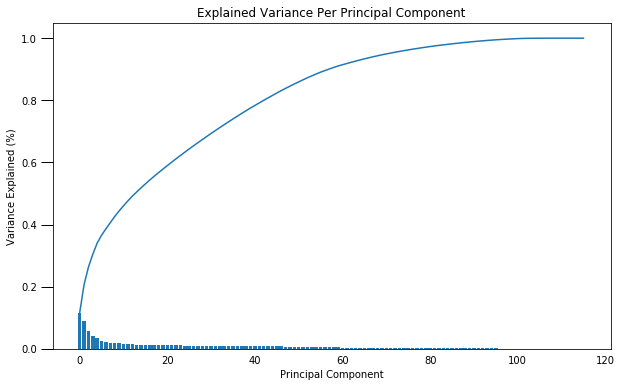

In [226]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [227]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca1 = PCA(n_components=58)
azdias_final_pca = pca1.fit_transform(azdias_final_std)

### Discussion 2.2: Perform Dimensionality Reduction

From the plot, we can see the first 58 components can explain roughly 90% of the variances of the data. Cross check with the cumulative sum of explained variance, I decided to retain the first 58 components which account for 0.90 of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [228]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_interpretation(model, num_component):
    return pd.Series(model.components_[num_component], index = azdias_fewNA_final.columns).sort_values(ascending=False)
    
pca_interpretation(pca1,0)

LP_STATUS_GROB_1.0       0.201760
HH_EINKOMMEN_SCORE       0.199264
PLZ8_ANTG3               0.189517
PLZ8_ANTG4               0.181696
EWDICHTE                 0.168248
ORTSGR_KLS9              0.167642
FINANZ_HAUSBAUER         0.162764
KBA05_ANTG4              0.135757
FINANZ_SPARER            0.131343
PLZ8_ANTG2               0.130993
FINANZTYP_1              0.128229
ANZ_HAUSHALTE_AKTIV      0.124917
ARBEIT                   0.121969
KBA05_ANTG3              0.120757
RELAT_AB                 0.116469
CAMEO_DEUG_2015_9        0.115994
SEMIO_REL                0.094718
SEMIO_PFLICHT            0.094251
CAMEO_DEUG_2015_8        0.091973
ZABEOTYP_5               0.083270
LP_FAMILIE_GROB_1.0      0.081244
SEMIO_RAT                0.078388
GEBAEUDETYP_3.0          0.072888
SEMIO_TRADV              0.070067
FINANZ_ANLEGER           0.065442
FINANZ_UNAUFFAELLIGER    0.062407
SEMIO_FAM                0.058992
SEMIO_MAT                0.058931
REGIOTYP                 0.056766
SEMIO_KULT    

first component has large positive associations with the large household size(more than 6 people family) and low household income; it is largely inversely related to small household size and number of small families in the area. So this first component is mainly about the household level demographics, particularly large family size households with low income and move often.

In [229]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_interpretation(pca1,1)

GENERATION               0.236750
ALTERSKATEGORIE_GROB     0.232261
FINANZ_VORSORGER         0.220408
ZABEOTYP_3               0.205235
SEMIO_ERL                0.191079
SEMIO_LUST               0.166015
RETOURTYP_BK_S           0.154217
W_KEIT_KIND_HH           0.121674
CJT_GESAMTTYP_2.0        0.110228
FINANZ_HAUSBAUER         0.109965
FINANZTYP_2              0.093929
FINANZTYP_5              0.093427
SEMIO_KRIT               0.081688
FINANZ_MINIMALIST        0.075172
SHOPPER_TYP_3.0          0.074174
EWDICHTE                 0.071205
NATIONALITAET_KZ_1.0     0.071057
SEMIO_KAEM               0.070729
CJT_GESAMTTYP_1.0        0.070683
FINANZTYP_6              0.070024
ORTSGR_KLS9              0.069304
PLZ8_ANTG3               0.069244
PLZ8_ANTG4               0.064666
WOHNDAUER_2008           0.061001
KBA05_ANTG4              0.058444
ARBEIT                   0.055380
ANREDE_KZ                0.054935
LP_FAMILIE_GROB_1.0      0.054640
ANZ_HAUSHALTE_AKTIV      0.054153
HH_EINKOMMEN_S

In [74]:
azdias_fewNA_final[['FINANZ_VORSORGER','FINANZ_SPARER']].head()

,FINANZ_VORSORGER,FINANZ_SPARER
1,2,5
2,1,4
3,5,2
4,4,3
5,5,1


The second component is positively correlated to increasing age and older generation, lower affinity to being prepared in financial investment, ie. low interest in financial investment. The top 2 negatively related features mean they have high affinity to saving money and are religious. The second component is mainly about personal level demographics, especially their financial typology. It's about older people who are money savers, religious and traditional-minded.

In [230]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_interpretation(pca1,2)

SEMIO_VERT               0.329152
SEMIO_SOZ                0.259897
SEMIO_FAM                0.257927
SEMIO_KULT               0.247919
FINANZ_MINIMALIST        0.136183
FINANZTYP_5              0.134959
SHOPPER_TYP_0.0          0.122917
ZABEOTYP_1               0.115088
SEMIO_REL                0.105771
RETOURTYP_BK_S           0.083768
W_KEIT_KIND_HH           0.076588
SEMIO_MAT                0.075909
GENERATION               0.067324
FINANZ_VORSORGER         0.065161
GREEN_AVANTGARDE         0.057796
MOVEMENT                 0.057796
SHOPPER_TYP_1.0          0.052879
EWDICHTE                 0.052746
ORTSGR_KLS9              0.051814
ZABEOTYP_6               0.051776
PLZ8_ANTG3               0.041610
PLZ8_ANTG4               0.041108
LP_STATUS_GROB_5.0       0.038847
SEMIO_LUST               0.035158
ARBEIT                   0.032373
RELAT_AB                 0.032217
ALTERSKATEGORIE_GROB     0.031637
PLZ8_ANTG2               0.030561
GEBAEUDETYP_3.0          0.027777
WOHNDAUER_2008

In [76]:
azdias_fewNA_final['ANREDE_KZ'].value_counts() # gender. 1=male, 2=female

2    416181
1    381886
Name: ANREDE_KZ, dtype: int64

The third component have more detailed person level demographics- their personalities and mindset. The top 5 negatively correlated fields means high affinity of those personality typology. The top negatively related "SEMIO" group features correspond to higher affinity of those characteristics while the top positive SEMIO features mean lower affinity of them. The high negative correlation to "ANREDE_KZ" indicates male (1= male).  This component is about people who are rational, dominant, aggresive and critically-minded, mostly male group.

### Discussion 2.3: Interpret Principal Components

The first component is on the community level, about the large size families(more than 6 people) in the neighborhood, since it's positively correlated with density of large family households in the region, Size of community, and negatively correlated with small family households in the region.

The second component is on person level. It mainly descibes people's financial typology. It's positively correlated to people's age, and people's conservative mindset. This component is about older people who are money savers, religious and traditional-minded.

The third component is also on person level. This component is about people who are rational, dominant, aggresive and critically-minded, mostly male group, since those fields are highly negatively corelated with the component. That means the higher the component's eigenvalues, the lower the values of those fields. And the lower values mean higher affinity to those personality types.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [77]:
from sklearn.cluster import KMeans
scores = []
Nc = range(1,25)
for n in Nc:
    kmeans = KMeans(n_clusters= n)
    kmeans.fit(azdias_final_pca)
    scores.append(kmeans.score(azdias_final_pca))    

([<matplotlib.axis.XTick at 0x1a310bc4a8>,
 <a list of 24 Text xticklabel objects>)

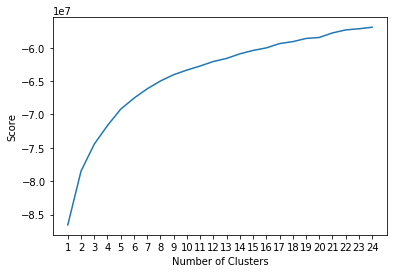

In [83]:
plt.plot(range(1,25),scores)

plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.xticks(range(1,25))  

([<matplotlib.axis.XTick at 0x1a31038320>,
 <a list of 24 Text xticklabel objects>)

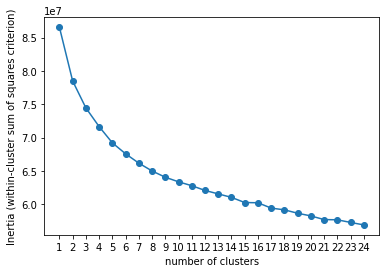

In [82]:
inertias = []
for n in Nc:
    kmeans = KMeans(n_clusters= n)
    kmeans.fit(azdias_final_pca)
    inertias.append(kmeans.inertia_)

plt.plot(Nc, inertias, '-o')
plt.xlabel('number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares criterion)')
plt.xticks(Nc)

([<matplotlib.axis.XTick at 0x1a32773128>,
 <a list of 24 Text xticklabel objects>)

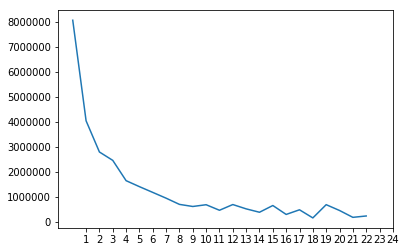

In [85]:
diff = []
for i in range(len(scores)-1):
    diff.append(scores[i+1]- scores[i])
plt.plot(diff)
plt.xticks(range(1,25))
# the difference of scores with increasing number of clusters gets significantly lower 

In [87]:
for i in range(len(diff)):
    print(i+1, diff[i], scores[i])

1 8065775.027803332 -86551623.59541863
2 4039537.6650016606 -78485848.5676153
3 2790214.2053738385 -74446310.90261364
4 2454785.755530849 -71656096.6972398
5 1642080.0930709988 -69201310.94170895
6 1402235.0580839962 -67559230.84863795
7 1172245.4556728378 -66156995.79055396
8 940934.2341194078 -64984750.33488112
9 692529.4185926244 -64043816.10076171
10 608739.8805125803 -63351286.68216909
11 679037.5450750142 -62742546.80165651
12 457274.07037845254 -62063509.25658149
13 686363.7422033921 -61606235.18620304
14 513259.64501826465 -60919871.44399965
15 377624.2363991812 -60406611.79898138
16 647528.8625883162 -60028987.5625822
17 290246.33345641196 -59381458.699993886
18 476058.57909647375 -59091212.366537474
19 150913.48359404504 -58615153.787441
20 681227.118372418 -58464240.303846955
21 448586.9815967232 -57783013.18547454
22 173782.66030912846 -57334426.203877814
23 228488.84702128917 -57160643.543568686


Both the score plot and and inertia plot indicate the "elbow", aka the starting point where the margine benefit of decrease in within cluster sum of square centrion with the increase of cluster number becomes plateaued, happpens around the cluster number 6-8. So I decide to keep 6 clusters.


In [242]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_final = KMeans(n_clusters= 6)
kmeans_final.fit(azdias_final_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [243]:
general_population_cluster = kmeans_final.predict(azdias_final_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [233]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [234]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [235]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_final = clean_data(customers)

/Users/lalago31/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lalago31/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [236]:
customers_final.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6',
       'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9',
       'GENERATION', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE'],
      dtype='object', length=115)

In [237]:
azdias_fewNA_final.loc[:,~azdias_fewNA_final.columns.isin(customers_final.columns)].head()

,GEBAEUDETYP_5.0
1,0
2,0
3,0
4,0
5,0


In [238]:
print(customers.GEBAEUDETYP.value_counts())
print(azdias.GEBAEUDETYP.value_counts())

1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
Name: GEBAEUDETYP, dtype: int64
1.0    460465
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: int64


* The general population has one more level of GEBAEUDETYP field than the customer data. Thus the imputer and standardscaler function cannot be directly applied on customer dataframe because of the difference in number of columns. I will have to add that GEBAEUDETYP_5.0 column to the customer dataset to make the number of columns equal, and since its value is mostly 0 in the general population dataset, I will assign value 0 to the added column in customer dataset.

In [239]:
np.unique(azdias_fewNA_final.loc[:,~azdias_fewNA_final.columns.isin(customers_final.columns)].values, return_counts= True)

(array([0, 1], dtype=uint8), array([798066,      1]))

In [240]:
customers_final['GEBAEUDETYP_5.0'] = 0
customers_clean = imp.transform(customers_final)  

In [260]:
#customers_clean = customers_final.fillna(customers_final.median())

In [244]:
customer_final_std = std.transform(customers_clean)
# Re-apply PCA to the data while selecting for number of components to retain.
customer_pca = pca1.transform(customer_final_std)

# predict customer cluster with fitted pca 
customer_cluster = kmeans_final.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [245]:
print(len(customer_cluster))
print(len(general_population_cluster))

141725
798067


In [246]:
# put the filtered outlier data points from customer dataset into a separate cluster
outlier_filtered_customer  = pd.Series(customers.shape[0] - customers_final.shape[0])
outlier_filtered_customer.rename({0:'outliers'},axis='index', inplace=True)
outlier_filtered_customer

outliers    49927
dtype: int64

In [247]:
pd.concat([pd.Series(customer_cluster).value_counts(),outlier_filtered_customer])/len(customers)
# filtered outliers account for 26% of the customer data

4           0.493097
3           0.155913
1           0.029183
2           0.027143
5           0.019400
0           0.014756
outliers    0.260509
dtype: float64

In [248]:
outlier_filtered_population  = pd.Series(azdias_lotsNA.shape[0])
outlier_filtered_population.rename({0:'outliers'},axis='index', inplace=True)
outlier_filtered_population

outliers    93154
dtype: int64

In [249]:
pd.concat([pd.Series(general_population_cluster).value_counts(),outlier_filtered_population])/len(azdias)
# filtered outliers(rows with lots of NA) account for 10% of the general population data

3           0.224174
5           0.180857
1           0.171086
0           0.151649
4           0.121913
2           0.045797
outliers    0.104524
dtype: float64

In [252]:
pd.concat([(pd.Series(general_population_cluster).value_counts()/len(azdias)).sort_index(), outlier_filtered_population/len(azdias)],axis=0)

0           0.151649
1           0.171086
2           0.045797
3           0.224174
4           0.121913
5           0.180857
outliers    0.104524
dtype: float64

In [250]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

Text(0,0.5,'proportion')

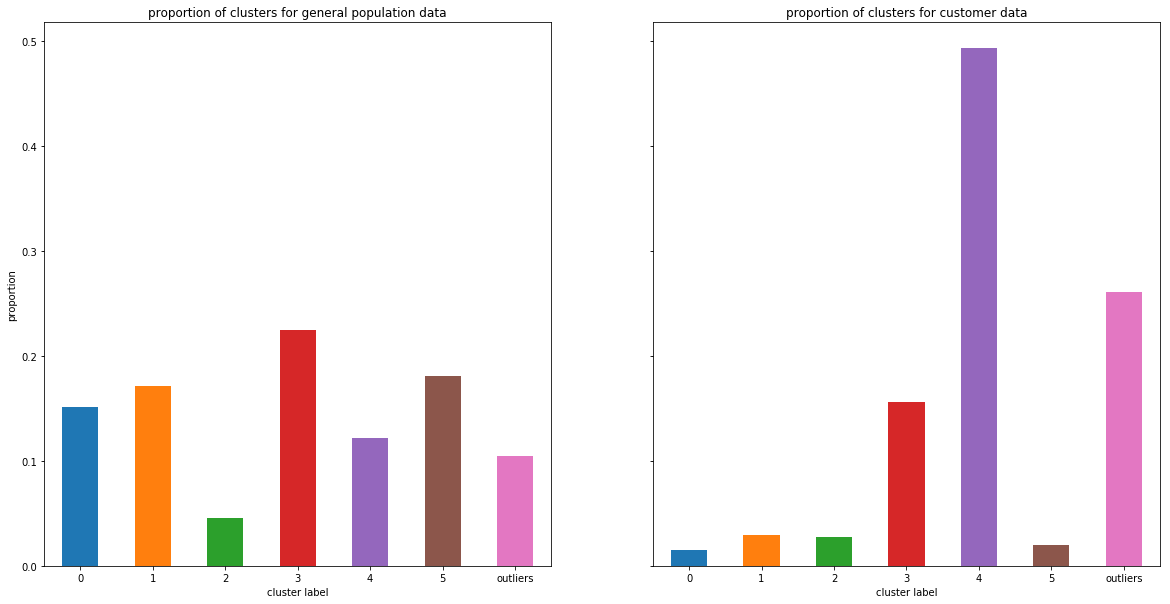

In [267]:
#fig = plt.figure(figsize=(20,10))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10),sharey=True)
#ax1 = fig.add_subplot(121)

#pd.Series(general_population_cluster).value_counts()/len(general_population_cluster)
general_population_cluster_proportion = pd.concat([(pd.Series(general_population_cluster).value_counts()/len(azdias)).sort_index(), outlier_filtered_population/len(azdias)],axis=0)
general_population_cluster_proportion.plot(kind='bar',rot=0, ax=ax1)
ax1.set_title('proportion of clusters for general population data')
ax1.set_xlabel('cluster label')
ax1.set_ylabel('proportion')


#ax2 = fig.add_subplot(122)

customer_cluster_proportion= pd.concat([(pd.Series(customer_cluster).value_counts()/len(customers)).sort_index(), outlier_filtered_customer/len(customers)],axis=0)
customer_cluster_proportion.plot(kind='bar',rot=0, ax=ax2)
ax2.set_title('proportion of clusters for customer data')
ax2.set_xlabel('cluster label')
ax2.set_ylabel('proportion')

In [255]:
combined_proportion = pd.concat([customer_cluster_proportion,general_population_cluster_proportion],axis=1).rename({0:'customer',1:'population'},axis=1)
combined_proportion['difference'] = combined_proportion['customer']-combined_proportion['population']
combined_proportion.sort_values(by='difference',ascending = False)

,customer,population,difference
4,0.493097,0.121913,0.371184
outliers,0.260509,0.104524,0.155985
2,0.027143,0.045797,-0.018654
3,0.155913,0.224174,-0.068262
0,0.014756,0.151649,-0.136893
1,0.029183,0.171086,-0.141902
5,0.019400,0.180857,-0.161458


cluster 4 has 37% more data points in the customer dataset than the general population! This is apparently the most overrepresented cluster in the customer dataset and is the potential customer group we want to reach out for the campaign. On the other hand, cluster 5 is the most underrepresented ones in customer data, accounting for around 16% less data points than that of the general population. 

In [256]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
customers_final['cluster_label'] = customer_cluster

In [258]:
customer_pca_df = pd.DataFrame(customer_pca, columns = ['PCA'+str(i) for i in range(58)])
customer_pca_df['cluster_label'] = customer_cluster
customer_pca_df.head()

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA49,PCA50,PCA51,PCA52,PCA53,PCA54,PCA55,PCA56,PCA57,cluster_label
0,-4.621578,1.779463,4.428417,-1.709915,4.299897,-2.198628,0.496268,2.029469,-2.027791,-0.798784,...,2.059819,0.738409,-0.190847,0.166637,-0.121378,1.273525,-2.701729,-0.527198,1.389075,4
1,-0.527364,4.938053,-0.558590,-0.524181,3.623090,-0.536344,-1.397913,-1.437893,1.513765,-0.519028,...,0.586658,0.459250,-0.128794,0.165392,-0.541191,0.832820,0.089260,0.938442,0.516159,4
2,-3.234089,0.027905,3.540816,-0.929665,-0.467640,0.447123,1.516450,-0.870095,0.083965,1.109445,...,0.612499,2.304859,-0.502199,2.149347,-0.212341,1.404941,-0.520098,0.653745,0.420452,4
3,2.118319,-0.950358,2.003619,-0.663527,1.653702,2.274239,0.766587,1.901534,0.732538,0.412208,...,0.131004,0.394270,-0.362444,2.034157,-0.184352,-0.197374,0.609696,1.495186,1.354793,5
4,-1.443754,0.869050,3.518346,-0.850880,4.672055,-0.254301,-0.484398,1.268261,2.655716,0.452415,...,-1.420452,2.379664,-0.312572,0.512752,-0.275089,-0.438865,-0.961808,-0.258578,-1.473301,4


In [259]:
customer_pca_df.loc[customer_pca_df['cluster_label']==4,:].head()

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA49,PCA50,PCA51,PCA52,PCA53,PCA54,PCA55,PCA56,PCA57,cluster_label
0,-4.621578,1.779463,4.428417,-1.709915,4.299897,-2.198628,0.496268,2.029469,-2.027791,-0.798784,...,2.059819,0.738409,-0.190847,0.166637,-0.121378,1.273525,-2.701729,-0.527198,1.389075,4
1,-0.527364,4.938053,-0.558590,-0.524181,3.623090,-0.536344,-1.397913,-1.437893,1.513765,-0.519028,...,0.586658,0.459250,-0.128794,0.165392,-0.541191,0.832820,0.089260,0.938442,0.516159,4
2,-3.234089,0.027905,3.540816,-0.929665,-0.467640,0.447123,1.516450,-0.870095,0.083965,1.109445,...,0.612499,2.304859,-0.502199,2.149347,-0.212341,1.404941,-0.520098,0.653745,0.420452,4
4,-1.443754,0.869050,3.518346,-0.850880,4.672055,-0.254301,-0.484398,1.268261,2.655716,0.452415,...,-1.420452,2.379664,-0.312572,0.512752,-0.275089,-0.438865,-0.961808,-0.258578,-1.473301,4
5,-5.093982,0.755222,3.797926,-2.224882,3.385692,-1.237585,-0.064906,1.265855,-0.768131,0.046235,...,1.475860,1.175895,-0.391075,1.433274,-0.063870,0.327408,-0.575906,0.990544,1.143245,4


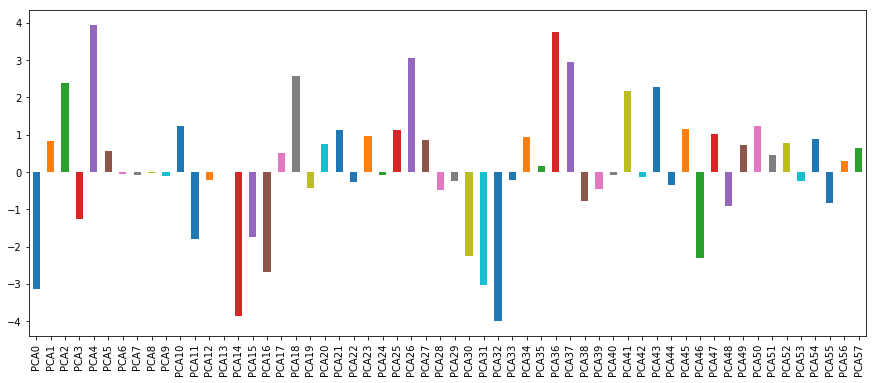

In [260]:
# relation between cluster 5 and each pca 
plt.figure(figsize=(15,6))
customer_pca_df.loc[customer_pca_df['cluster_label']==4,:].iloc[:,:-1].mean().plot.bar()

* PCA 4,2, 26 are most positively related to cluster 4, while PCA 0, 14 are the most negatively related component

In [269]:
pca_interpretation(pca1,4)

MOVEMENT                 0.325889
GREEN_AVANTGARDE         0.325889
LP_STATUS_GROB_5.0       0.252027
EWDICHTE                 0.246922
ORTSGR_KLS9              0.237036
ZABEOTYP_2               0.149837
ONLINE_AFFINITAET        0.135106
ANZ_PERSONEN             0.127065
PLZ8_ANTG3               0.119633
CAMEO_DEUG_2015_1        0.112398
SEMIO_DOM                0.111471
PLZ8_ANTG4               0.111293
FINANZTYP_5              0.111010
PLZ8_HHZ                 0.100777
PLZ8_ANTG2               0.097779
SEMIO_KAEM               0.097770
RELAT_AB                 0.097718
FINANZTYP_3              0.094144
ZABEOTYP_1               0.093776
LP_FAMILIE_GROB_5.0      0.090672
MIN_GEBAEUDEJAHR         0.088793
WEALTH                   0.083613
CAMEO_DEUG_2015_2        0.076003
SHOPPER_TYP_3.0          0.075178
LP_STATUS_GROB_3.0       0.072230
FINANZ_UNAUFFAELLIGER    0.069324
OST_WEST_KZ              0.068346
ARBEIT                   0.067194
LP_FAMILIE_GROB_4.0      0.066690
GEBAEUDETYP_3.

The top PC that has a high positive correlation with cluster 4 is PCA4. This PC is highly correlated to high income people who have very high purchasing powers, have high environmental sustainability awareness when they are young. They are avantgarde whose mindset and ideas are always ahead of the time. they are keen to try cutting-edge things and enjoy going online. They are mature upper class households with kids(6-10 people). Location-wise, they live close to urban centers. In a nutshell, they are avantgarde-minded top earners of mature households in the urban region.

In [270]:
pca_interpretation(pca1,2)

SEMIO_VERT               0.329152
SEMIO_SOZ                0.259897
SEMIO_FAM                0.257927
SEMIO_KULT               0.247919
FINANZ_MINIMALIST        0.136183
FINANZTYP_5              0.134959
SHOPPER_TYP_0.0          0.122917
ZABEOTYP_1               0.115088
SEMIO_REL                0.105771
RETOURTYP_BK_S           0.083768
W_KEIT_KIND_HH           0.076588
SEMIO_MAT                0.075909
GENERATION               0.067324
FINANZ_VORSORGER         0.065161
GREEN_AVANTGARDE         0.057796
MOVEMENT                 0.057796
SHOPPER_TYP_1.0          0.052879
EWDICHTE                 0.052746
ORTSGR_KLS9              0.051814
ZABEOTYP_6               0.051776
PLZ8_ANTG3               0.041610
PLZ8_ANTG4               0.041108
LP_STATUS_GROB_5.0       0.038847
SEMIO_LUST               0.035158
ARBEIT                   0.032373
RELAT_AB                 0.032217
ALTERSKATEGORIE_GROB     0.031637
PLZ8_ANTG2               0.030561
GEBAEUDETYP_3.0          0.027777
WOHNDAUER_2008

PCA 2 is mostly competitive, critically minded and rantional male who like to shop for family. They might be home owners and very interested in investing.

In [272]:
pca_interpretation(pca1,26)

LP_FAMILIE_GROB_2.0     0.354723
CAMEO_DEUG_2015_3       0.301847
SHOPPER_TYP_2.0         0.276595
CAMEO_DEUG_2015_5       0.201111
CAMEO_DEUG_2015_9       0.175573
FINANZTYP_4             0.174619
LP_STATUS_GROB_2.0      0.138127
CJT_GESAMTTYP_3.0       0.132658
FINANZTYP_2             0.129705
ANZ_HH_TITEL            0.127069
CJT_GESAMTTYP_5.0       0.114209
HEALTH_TYP              0.107150
ZABEOTYP_5              0.101894
GEBAEUDETYP_1.0         0.100015
ANZ_HAUSHALTE_AKTIV     0.098631
ONLINE_AFFINITAET       0.079503
LP_FAMILIE_GROB_3.0     0.076953
GREEN_AVANTGARDE        0.065736
MOVEMENT                0.065736
PLZ8_ANTG4              0.063934
LP_FAMILIE_GROB_4.0     0.061774
NATIONALITAET_KZ_2.0    0.060074
CJT_GESAMTTYP_2.0       0.058945
PLZ8_ANTG2              0.052641
PLZ8_ANTG3              0.051662
LP_STATUS_GROB_5.0      0.051655
KBA05_ANTG4             0.050968
BALLRAUM                0.048207
OST_WEST_KZ             0.043732
FINANZ_MINIMALIST       0.039604
          

PCA26 is about established middle class couples, financially prepared

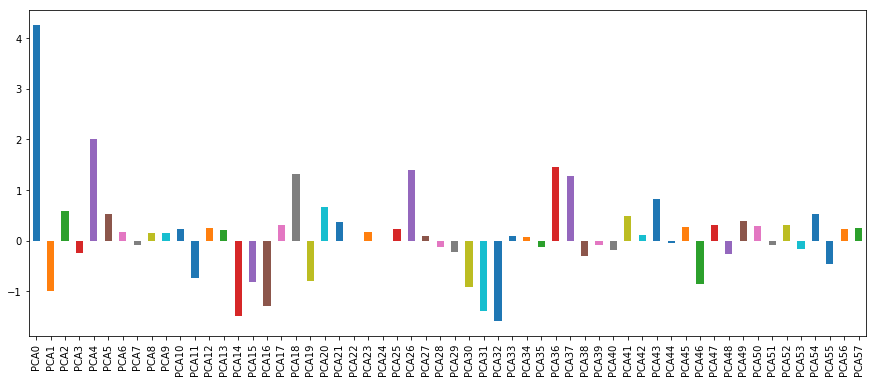

In [273]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# cluster 0 is the most underrepresented group as the chart above shows. 
# The biggest affect component of cluster 0 is pca 0
plt.figure(figsize=(15,6))
customer_pca_df.loc[customer_pca_df['cluster_label']==5,:].iloc[:,:-1].mean().plot.bar()

In [274]:
pca_interpretation(pca1,0)

LP_STATUS_GROB_1.0       0.201760
HH_EINKOMMEN_SCORE       0.199264
PLZ8_ANTG3               0.189517
PLZ8_ANTG4               0.181696
EWDICHTE                 0.168248
ORTSGR_KLS9              0.167642
FINANZ_HAUSBAUER         0.162764
KBA05_ANTG4              0.135757
FINANZ_SPARER            0.131343
PLZ8_ANTG2               0.130993
FINANZTYP_1              0.128229
ANZ_HAUSHALTE_AKTIV      0.124917
ARBEIT                   0.121969
KBA05_ANTG3              0.120757
RELAT_AB                 0.116469
CAMEO_DEUG_2015_9        0.115994
SEMIO_REL                0.094718
SEMIO_PFLICHT            0.094251
CAMEO_DEUG_2015_8        0.091973
ZABEOTYP_5               0.083270
LP_FAMILIE_GROB_1.0      0.081244
SEMIO_RAT                0.078388
GEBAEUDETYP_3.0          0.072888
SEMIO_TRADV              0.070067
FINANZ_ANLEGER           0.065442
FINANZ_UNAUFFAELLIGER    0.062407
SEMIO_FAM                0.058992
SEMIO_MAT                0.058931
REGIOTYP                 0.056766
SEMIO_KULT    

The underrepresented cluster is majorly composed of PCA 0 which is mainly large low income earners living in very crowded community with high share of large households (6+ people). and they tend to move a lot maybe because of unstable income. This is apparently the group the company don't want to target.

### Discussion 3.3: Compare Customer Data to Demographics Data
Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?


* From the analysis of the highly concentrated Principle components of the overrepresented cluster(cluster #4), I would recommend the audience that mail-order company might target are high income urban dwellers who have high environmental sustainability awareness when they are young. They are avantgarde whose mindset and ideas are always ahead of the time. They are keen to try cutting-edge things and are big internet users. They are mature upper class households with kids(6-10 people). Location-wise, they live close to urban centers. In a nutshell, they are avantgarde-minded top earners of mature households in the urban region.


* The most underrepresented cluster(cluster #0) is mainly composed of PC0 which is mainly low income earners living in very crowded communities full of large housefholds(6+ people) and they tend to move around a lot and do not have a stable location. People in this type of households are relatively unpopular with the company. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.